In [17]:
using Plots
import Pkg; Pkg.add("DataFrames")
using DataFrames
using Statistics
using Plots
import Pkg; Pkg.add("PlotlyJS")
using Pkg
Pkg.add("IJulia")
import Pkg; Pkg.add("PyPlot")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
   Installed PyCall ─ v1.96.4
   Installed PyPlot ─ v2.11.5
    Updating `~/.julia/environments/v1.10/Project.toml`
  [d330b81b] + PyPlot v2.11.5
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [438e738f] + PyCall v1.96.4
  [d330b81b] + PyPlot v2.11.5
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`
Precompiling project...
  ✓ PyCall
  ✓ PyPlot
  2 dependencies successfully precompiled in 10 seconds. 223 alread

In [2]:
function calc_angle(transduct_dis::Float64, diameter::Float64)
    theta_rad::Float64 = atan(diameter / transduct_dis)
    theta_degree::Float64 = rad2deg(theta_rad)
    L_dis::Float64 = sqrt(transduct_dis^2 + diameter^2)
    return theta_degree, L_dis
end

calc_angle (generic function with 1 method)

In [3]:
function calc_velocity(angle::Float64, L_dis::Float64, vel::Float64)
    c::Float64 = 1480.00
    td = L_dis / (c + vel * cosd(angle))
    tu = L_dis / (c - vel * cosd(angle))
    delta_time = tu - td
    v::Float64 = (L_dis * delta_time) / (2 * cosd(angle) * tu * td)
    return v
end

calc_velocity (generic function with 1 method)

In [4]:
function add_noise(value::Float64, noise_level::Float64)
    return value + (randn()*2-1) * noise_level
end

add_noise (generic function with 1 method)

In [5]:
# Função para calcular o perfil de velocidade parabólico
function parabolic_velocity_profile(r::Float64, R::Float64, vmax::Float64)
    return vmax * (1 - (r / R)^2)
end

# Função para calcular o tempo de trânsito usando o perfil parabólico
function calc_vel_parabolic(angle::Float64, L_dis::Float64, R::Float64, vmax::Float64)
    c = 1480.0
    num_points = 100
    rs = range(-R, stop=R, length=num_points)
    vs = parabolic_velocity_profile.(rs, R, vmax)
    avg_velocity = mean(vs)
    td = L_dis / (c + avg_velocity * cosd(angle))
    tu = L_dis / (c - avg_velocity * cosd(angle))
    delta_time = tu - td
    v::Float64 = (L_dis * delta_time) / (2 * cosd(angle) * tu * td)
    return [v]
end

calc_vel_parabolic (generic function with 1 method)

In [6]:
function calc_MAE(v::Vector{Float64}, v_hat::Vector{Float64})
    return mean(abs.(v .- v_hat))
end

calc_MAE (generic function with 1 method)

In [7]:
len = 5
velocitys = collect(range(0.1, 10.0, length=len))  # Velocities in m/s
distance_btw_transductores = collect(range(0.1, 50, length=len))  # cm
diameters = collect(range(0.1, 50.0, length=len))  # cm


true_velocities = Float64[]
noisy_velocities = Float64[]
errors = Float64[]
parameter_combinations = []


for velocity in velocitys
    for distance in distance_btw_transductores
        for diameter in diameters
            angle, L_dis = calc_angle(distance, diameter)
            true_velocity = calc_velocity(angle, L_dis, velocity)
            push!(true_velocities, true_velocity)
            noisy_velocity = add_noise(true_velocity, 0.01)
            push!(noisy_velocities, noisy_velocity)
            error = calc_MAE([true_velocity], [noisy_velocity])
            push!(errors, error)
            push!(parameter_combinations, (velocity, distance, diameter))
        end
    end
end



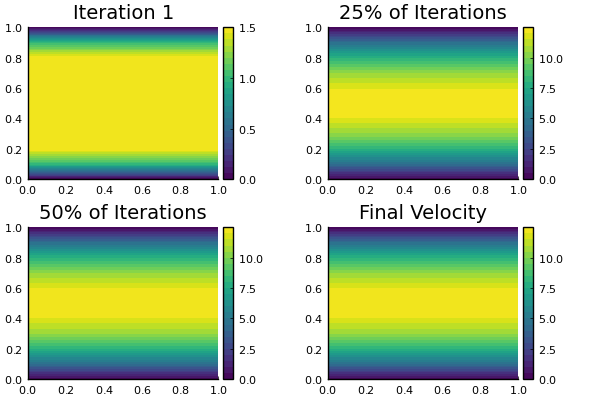

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [69]:
using LinearAlgebra
using Plots
pyplot()

# Simulation Parameters
N_POINTS = 11
KINEMATIC_VISCOSITY = 0.01
TIME_STEP_LENGTH = 0.5
N_TIME_STEPS = 500
PRESSURE_GRADIENT = [-1.0, 0.0]

element_length = 1.0 / (N_POINTS - 1)
x_range = range(0.0, stop=1.0, length=N_POINTS)
y_range = range(0.0, stop=1.0, length=N_POINTS)

coordinates_x = [x for x in x_range, y in y_range]
coordinates_y = [y for x in x_range, y in y_range]

function central_difference_x_periodic(field, element_length)
    diff = (circshift(field, (0, 1)) - circshift(field, (0, -1))) / (2 * element_length)
    return diff
end

function laplace_periodic(field, element_length)
    diff = (circshift(field, (0, 1)) + circshift(field, (1, 0)) +
            circshift(field, (0, -1)) + circshift(field, (-1, 0)) -
            4 * field) / element_length^2
    return diff
end

velocity_x_prev = ones(N_POINTS, N_POINTS)
velocity_x_prev[1, :] .= 0.0
velocity_x_prev[end, :] .= 0.0

# Containers for saving velocity fields at different stages
velocity_x_instant_1 = copy(velocity_x_prev)
velocity_x_instant_2 = copy(velocity_x_prev)
velocity_x_instant_3 = copy(velocity_x_prev)
velocity_x_final = copy(velocity_x_prev)

for iter in 1:N_TIME_STEPS
    convection_x = velocity_x_prev .* central_difference_x_periodic(velocity_x_prev, element_length)
    diffusion_x = KINEMATIC_VISCOSITY * laplace_periodic(velocity_x_prev, element_length)

    velocity_x_next = velocity_x_prev .+ TIME_STEP_LENGTH * (-PRESSURE_GRADIENT[1] .+ diffusion_x .- convection_x)

    velocity_x_next[1, :] .= 0.0
    velocity_x_next[end, :] .= 0.0

    # Save velocity field snapshots
    if iter == 1
        velocity_x_instant_1 .= velocity_x_next
    elseif iter == Int(N_TIME_STEPS * 0.25)
        velocity_x_instant_2 .= velocity_x_next
    elseif iter == Int(N_TIME_STEPS * 0.5)
        velocity_x_instant_3 .= velocity_x_next
    elseif iter == N_TIME_STEPS
        velocity_x_final .= velocity_x_next
    end

    velocity_x_prev = velocity_x_next
end

# Plot the velocity field snapshots for comparison
p1 = contourf(coordinates_y, coordinates_x, velocity_x_instant_1, levels=25, title="Iteration 1", color=:viridis)
p2 = contourf(coordinates_y, coordinates_x, velocity_x_instant_2, levels=25, title="25% of Iterations", color=:viridis)
p3 = contourf(coordinates_y, coordinates_x, velocity_x_instant_3, levels=25, title="50% of Iterations", color=:viridis)
p4 = contourf(coordinates_y, coordinates_x, velocity_x_final, levels=25, title="Final Velocity", color=:viridis)

# Show the plots together
plot(p1, p2, p3, p4, layout=(2,2))


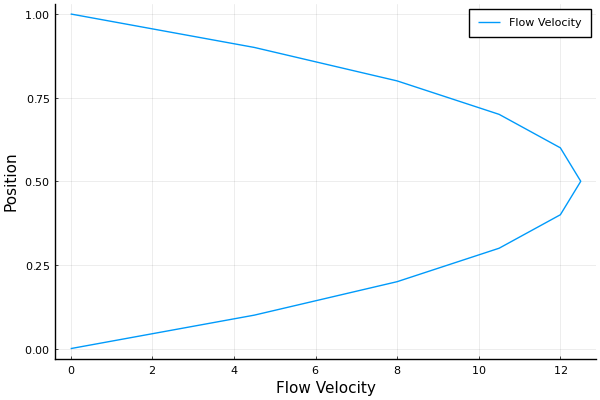

In [67]:
plot(velocity_x_prev[:, 2], y_range, label="Flow Velocity", xlabel="Flow Velocity", ylabel="Position")